In [1]:
import os
from PIL import Image
import sys 
import typing as t
import random

import numpy as np
import matplotlib.pyplot as plt

# add src to path
sys.path.append('..')
from utils.db_helper import get_files_paths_recursive

In [2]:
SOURCE_DIR_V1 = "C:/database/StyleGanv1"
SOURCE_DIR_V2 = "C:/database/StyleGanv2"
SOURCE_DIR_FFHQ = "C:/database/FFHQ"



In [3]:
def get_data(src_path: str, random_shuffle=True)-> t.Generator[np.ndarray, None, None]:
    images_paths = get_files_paths_recursive(src_path)
    if random_shuffle:
        random.shuffle(images_paths)
    print(f"len: {len(images_paths)}")
    for image_path in images_paths[:200]:
        tmp_image = Image.open(image_path)
        np_image = np.array(tmp_image).astype(np.float32) / 255
        tmp_image.close()
        yield np_image


In [4]:
def dft_from_single_channel(np_channel: np.ndarray)-> np.ndarray:
        np_fft = np.fft.fft2(np_channel)
        np_fft = np.fft.fftshift(np_fft)
        np_fft = np.log(np.abs(np_fft)+1e-3)
        #normalize
        fft_min = np.percentile(np_fft,5)
        fft_max = np.percentile(np_fft,95)
        np_fft = (np_fft - fft_min)/(fft_max - fft_min)
        np_fft[np_fft<0] = 0
        np_fft[np_fft>1] = 1
        return np_fft

In [5]:
def dft_from_image(np_img: np.ndarray)-> np.ndarray:
    np_fft = np.empty(np_img.shape)
    if len(np_img.shape) == 3:
        for i in range(np_img.shape[-1]):
            np_fft[:,:,i] = dft_from_single_channel(np_img[:,:,i])
    elif len(np_img.shape) == 2:
        np_fft = dft_from_single_channel(np_img)
    else:
        raise ValueError('Bad shape of the image')
    return np_fft


In [6]:
def dft_from_dataset(src_path: str)-> np.ndarray:
    print("Loading dataset...")
    dataset_gen = get_data(src_path)
    print("Processing database...")
    np_fft_dataset = np.zeros(next(dataset_gen).shape, dtype=np.float32)
    number_of_images = 0
    for np_image in dataset_gen:
        np_tmp_fft = dft_from_image(np_image)
        np_fft_dataset += np_tmp_fft
        number_of_images +=1
    return np_fft_dataset / number_of_images
        
        


In [7]:
stylev1_datagen = get_data(SOURCE_DIR_V1)
stylev2_datagen = get_data(SOURCE_DIR_V2)
ffhq_datagen = get_data(SOURCE_DIR_FFHQ)

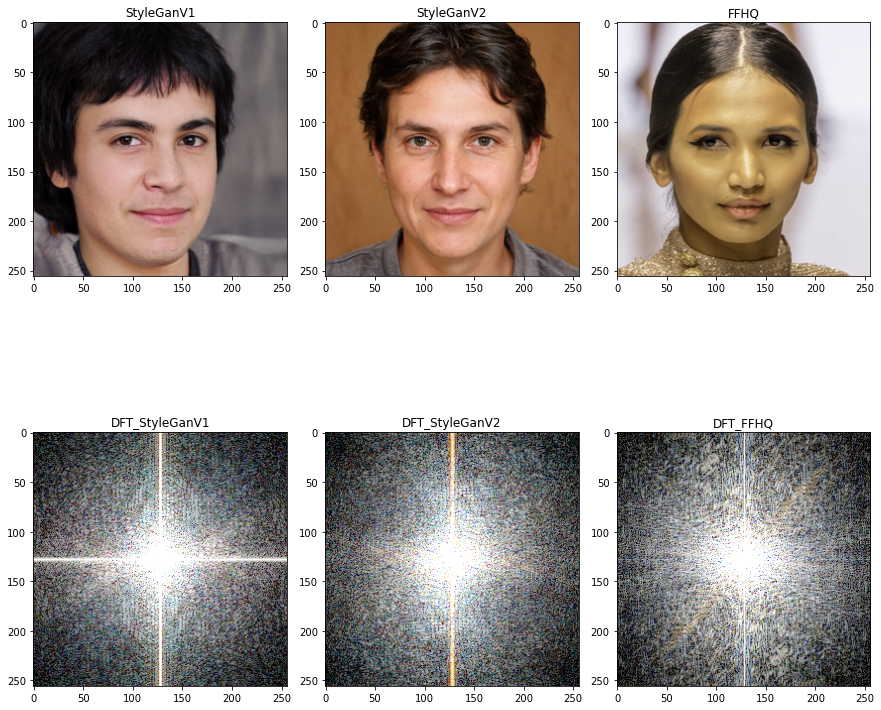

In [23]:
v1_image = next(stylev1_datagen)
v2_image = next(stylev2_datagen)
ffhq_image = next(ffhq_datagen)


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
axs[0,0].set_title('StyleGanV1')
axs[0,0].imshow(v1_image)

axs[1,0].set_title('DFT_StyleGanV1')
axs[1,0].imshow(dft_from_image(v1_image))

axs[0,1].set_title('StyleGanV2')
axs[0,1].imshow(v2_image)

axs[1,1].set_title('DFT_StyleGanV2')
axs[1,1].imshow(dft_from_image(v2_image))

axs[0,2].set_title('FFHQ')
axs[0,2].imshow(ffhq_image)

axs[1,2].set_title('DFT_FFHQ')
axs[1,2].imshow(dft_from_image(ffhq_image))
plt.subplots_adjust(wspace=0.15, hspace=0.01)


In [21]:
type(ax[0])

numpy.ndarray